In [1]:
import warnings
import pandas as pd
pd.set_option('display.max_columns', 10)
warnings.filterwarnings('ignore')

data = pd.read_csv('house_price.csv')

print(f'data shape = {data.shape}')
data.head(2)

data shape = (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,...,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,...,5,2007,WD,Normal,181500


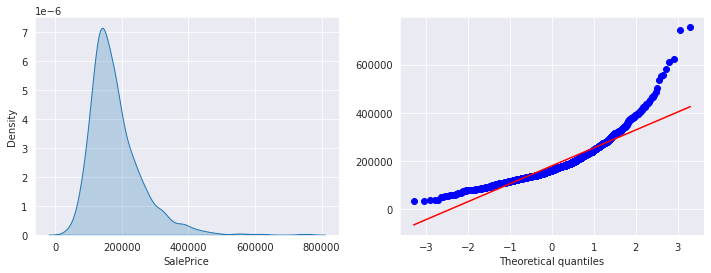

In [2]:
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(12, 4)

sns.kdeplot(
    data=data, x='SalePrice', shade=True, 
    ax=ax1
)
sp.stats.probplot(
    data.SalePrice, 
    plot=ax2
)
ax2.set(title=None, ylabel=None)

plt.show()

In [3]:
import numpy as np

# this function is make a pipeline.

def log_scaler(x):
    return np.log1p(x)

data.SalePrice = data.SalePrice.apply(log_scaler)

print(f'data shape = {data.shape}')
data.head(2)

data shape = (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,...,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,...,5,2007,WD,Normal,12.109016


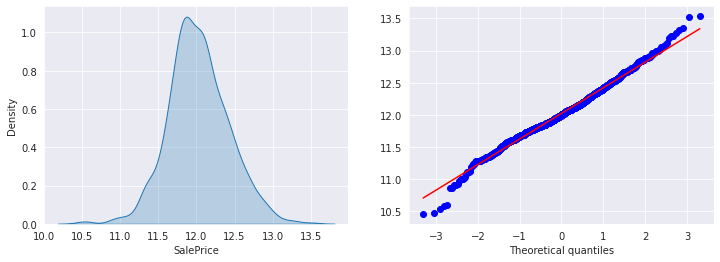

In [4]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(12, 4)

sns.kdeplot(
    data=data, x='SalePrice', shade=True, 
    ax=ax1
)
sp.stats.probplot(
    data.SalePrice, 
    plot=ax2
)
ax2.set(title=None, ylabel=None)

plt.show()

In [5]:
from sklearn.model_selection import train_test_split

x_data = data.copy()
x_data = pd.get_dummies(
    x_data, dummy_na=True
).dropna(axis=0)

y_data = x_data.pop('SalePrice')

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.3, random_state=27
)
train_ind, test_ind = x_train.index, x_test.index

print(f'train shape = {x_train.shape}, {y_train.shape}')
x_train.head(2)

train shape = (784, 332), (784,)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
834,835,20,75.0,7875,5,...,0,0,1,0,0
1393,1394,190,60.0,10800,6,...,0,0,1,0,0


In [6]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=50)
selector.fit_transform(x_train, y_train)

selected_mask = selector.get_support()
all_feature = x_train.columns

selected_feature = all_feature[selected_mask]

selection = pd.DataFrame(
    [c.split('_') for c in selected_feature], 
    columns=['ImportantFeature', 'ImportantValue']
)
selection.T

,0,1,2,3,4,...,45,46,47,48,49
ImportantFeature,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,...,GarageType,GarageFinish,GarageFinish,SaleType,SaleCondition
ImportantValue,None,None,None,None,None,...,Detchd,Fin,Unf,New,Partial


In [8]:
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import root_mean_squared_error

minute = 10

automl = AutoSklearnRegressor(
    load_models=True,
    time_left_for_this_task=60*minute,
    resampling_strategy='cv',
    metric=root_mean_squared_error,
    ensemble_size=5,
    memory_limit=10**4,
    seed=27,
)
automl.fit(
    x_train[selected_feature], 
    y_train
)

AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     ensemble_kwargs={'ensemble_size': 5}, ensemble_size=5,
                     memory_limit=10000, metric=root_mean_squared_error,
                     per_run_time_limit=60, resampling_strategy='cv', seed=27,
                     time_left_for_this_task=600)

In [9]:
y_pred = automl.predict(
    x_test[selected_feature]
)
test_score = root_mean_squared_error(
    y_test, y_pred
)

# this score is baseline.

print(f'test score = {-test_score:.5f}')

automl.leaderboard()

test score = 0.12952


,rank,ensemble_weight,type,cost,duration
model_id,,,,,
2,1,0.8,random_forest,0.155424,34.86202
15,2,0.2,ard_regression,0.182434,7.45514


In [10]:
data.loc[test_ind, 'PredSalePrice'] = y_pred

data.loc[train_ind, 'IsTrain'] = True
data.loc[test_ind, 'IsTrain'] = False
print(f'trainset ind \n{data.IsTrain.value_counts()}')

data.to_csv('house_price_label.csv', header=True, index=False)

print(f'data shape = {data.shape}')
data.head(2)

trainset ind 
True     784
False    337
Name: IsTrain, dtype: int64
data shape = (1460, 83)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,SaleType,SaleCondition,SalePrice,PredSalePrice,IsTrain
0,1,60,RL,65.0,8450,...,WD,Normal,12.247699,NaN,True
1,2,20,RL,80.0,9600,...,WD,Normal,12.109016,NaN,True


In [11]:
data.loc[test_ind, 'PredSalePrice'] = y_pred

data.loc[train_ind, 'IsTrain'] = True
data.loc[test_ind, 'IsTrain'] = False

data.to_csv('house_price_label.csv', header=True, index=False)

print(f'data shape = {data.shape}')
print(data.IsTrain.value_counts())

data.head(2)

data shape = (1460, 83)
True     784
False    337
Name: IsTrain, dtype: int64


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,...,SaleType,SaleCondition,SalePrice,PredSalePrice,IsTrain
0,1,60,RL,65.0,8450,...,WD,Normal,12.247699,NaN,True
1,2,20,RL,80.0,9600,...,WD,Normal,12.109016,NaN,True
